# Xception Pretrained Network Fine Tuning 15 Last Layers


In this run for the Xception, we froze all layers but the last 15 and added two dense layers after the conv_base.

Best Epoch: 90

test acc: 0,90183

test loss: 3,01577

f1_score: 0,90326

Precision: 0,89025

Recall: 0,91666

ROC AUC: 0,90183

---Training:  seconds --- 21164.3 s

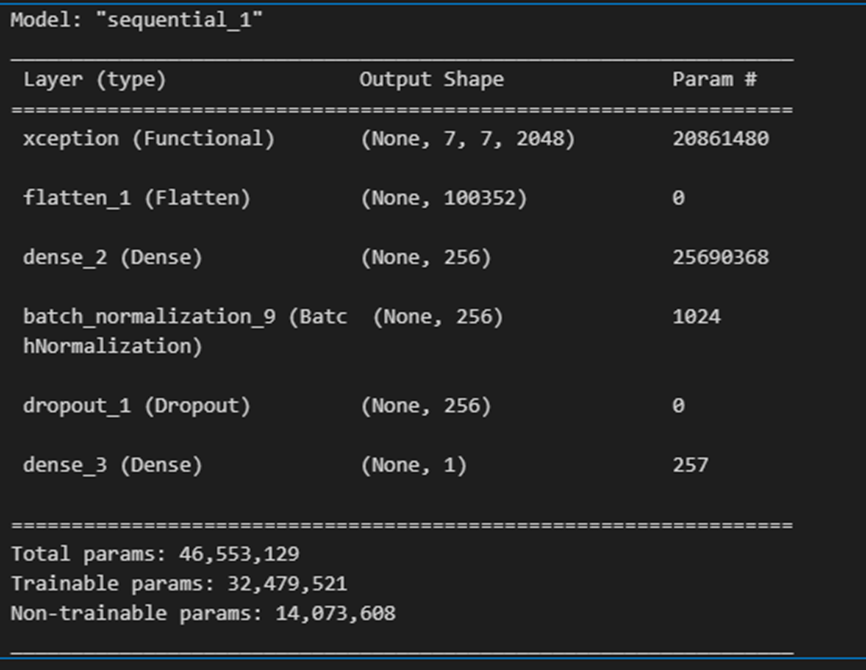

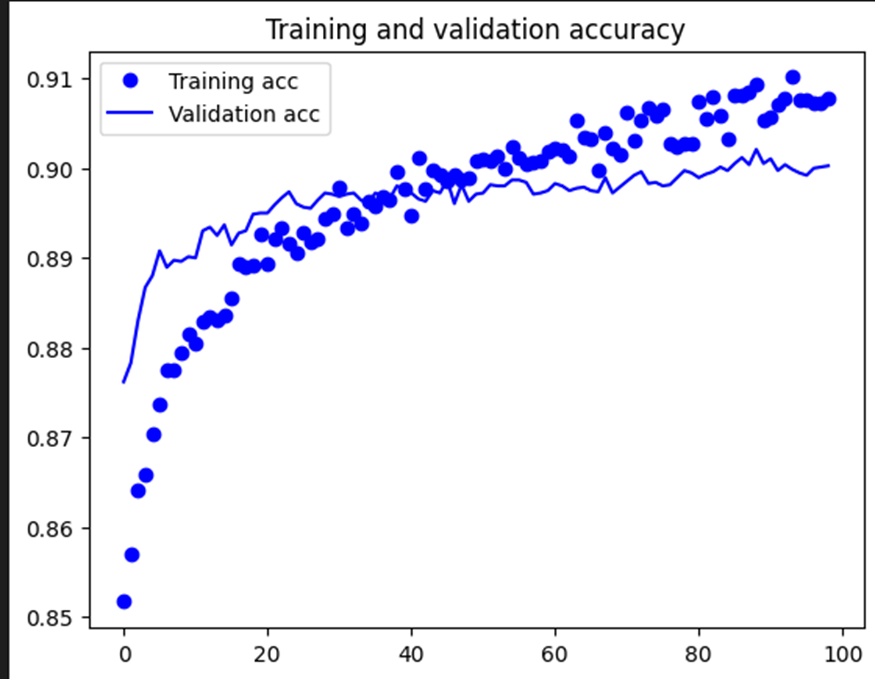

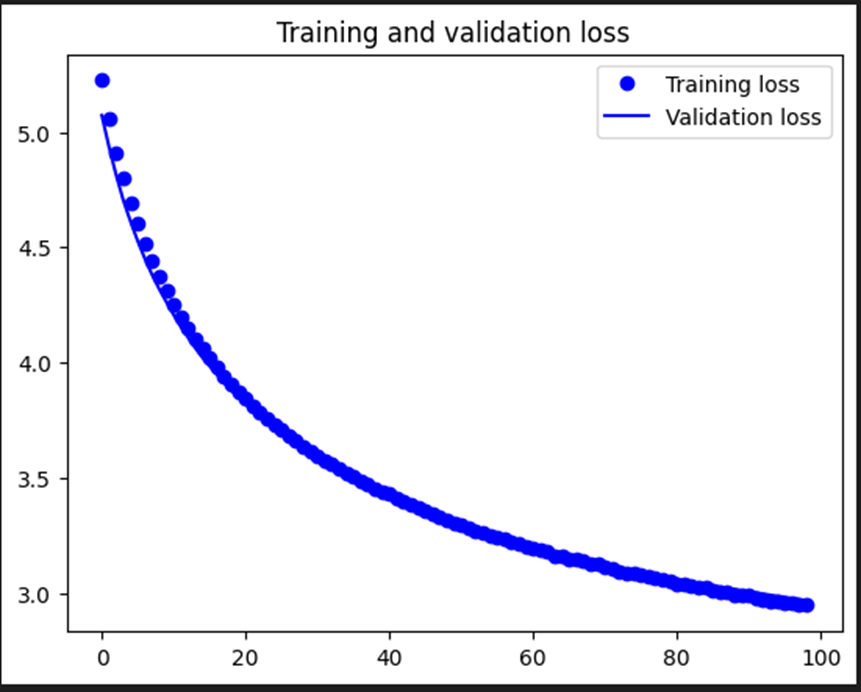

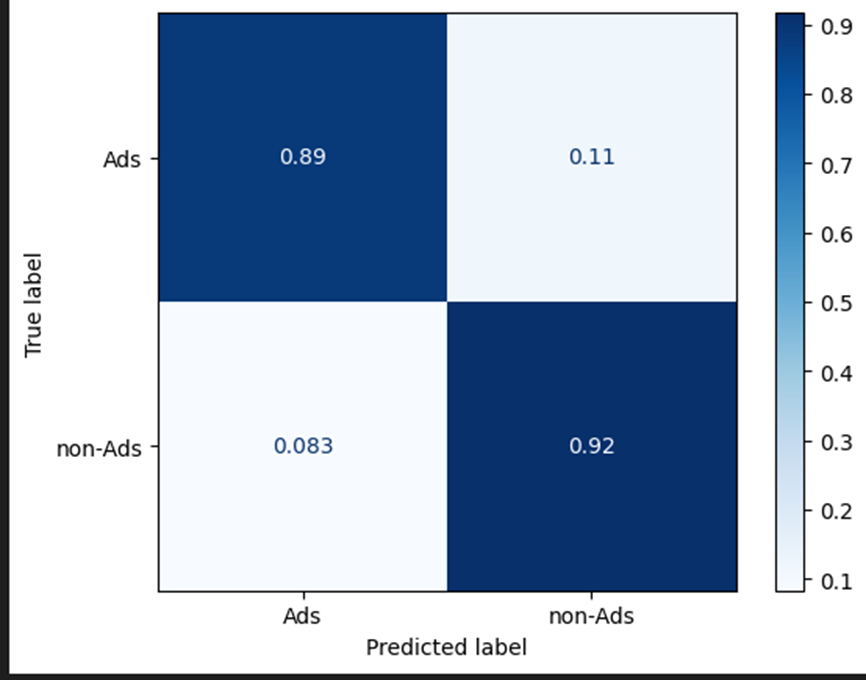

In [51]:
#!pip install "tensorflow<2.11"

In [52]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [53]:
#!pip install torchvision

In [54]:

#!pip list
import torch

In [55]:
#!nvidia-smi

In [56]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [57]:
# add headings with ##(space) on the markdowns

In [58]:
#!pip install tensorflor keras

In [59]:
import tensorflow as tf
import os

In [60]:
!nvidia-smi

Fri Jun 21 19:07:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:2D:00.0  On |                  N/A |
| 60%   50C    P8              17W / 125W |   5596MiB /  6144MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [61]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [62]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [63]:
#! nvidia-smi

In [64]:
#!pip install opencv-python

## Imports

In [65]:
import tensorflow as tf
import os
import cv2
import imghdr

In [66]:
import numpy as np
from matplotlib import pyplot as plt

In [67]:
class TrainingConfig:
    BATCH_SIZE:       int   = 64
    EPOCHS:           int   = 100
    LEARNING_RATE:    float = 0.001
    DROPOUT:          float = 0.5
    LAYERS_FINE_TUNE: int   = 15
    EPSILON:          float = 1e-07
    MOMENTUM:         float = 0.9   
    WEIGHT_DECAY:     float = 0.0005 

# Split Data

In [68]:
base_dir = r"C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\READY_BALANCED_SAME_SIZE_Random_Split"

In [69]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [70]:
train_Ads_dir = os.path.join(train_dir, 'Ads')
train_sample_dir = os.path.join(train_dir, 'Sample')
train_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\train\\Ads'

In [71]:
validation_Ads_dir = os.path.join(validation_dir, 'Ads')
validation_sample_dir = os.path.join(validation_dir, 'Sample')
validation_Ads_dir


'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\validation\\Ads'

In [72]:
test_Ads_dir = os.path.join(test_dir, 'Ads')
test_sample_dir = os.path.join(test_dir, 'Sample')
test_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\test\\Ads'

In [73]:
print('total training Ads images:', len(os.listdir(train_Ads_dir)))

total training Ads images: 10500


In [74]:
print('total training sample images:', len(os.listdir(train_sample_dir)))

total training sample images: 10500


In [75]:
print('total validation Ads images:', len(os.listdir(validation_Ads_dir)))

total validation Ads images: 3650


In [76]:
print('total validation sample images:', len(os.listdir(validation_sample_dir)))

total validation sample images: 3950


In [77]:
print('total test Ads images:', len(os.listdir(test_Ads_dir)))

total test Ads images: 3000


In [78]:
print('total test sample images:', len(os.listdir(test_sample_dir)))

total test sample images: 3000


## Using data augmentation/ datagen

In [79]:
import numpy as np
from PIL import ImageEnhance
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.utils import img_to_array, array_to_img,  load_img

In [80]:
# Custom preprocessing function for color augmentation
def color_jitter(image):
    image = ImageEnhance.Brightness(image).enhance(np.random.uniform(0.4, 1.6)) # from -60% to +60%
    image = ImageEnhance.Contrast(image).enhance(np.random.uniform(0.4, 1.6))
    image = ImageEnhance.Color(image).enhance(np.random.uniform(0.4, 1.6))
    return image

In [81]:
# Custom preprocessing function for ImageDataGenerator
def custom_preprocessing_function(image):
    # Convert array to PIL image
    image = array_to_img(image)
    # Apply color jitter
    image = color_jitter(image)
    # Convert PIL image back to array
    image = img_to_array(image)
    return image

In [82]:
from keras.preprocessing.image import ImageDataGenerator

## with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=custom_preprocessing_function)


#train_datagen = ImageDataGenerator(
#    rescale=1./255)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE,
        class_mode='binary')

Found 21000 images belonging to 2 classes.
Found 7600 images belonging to 2 classes.


## Pretrained Model Inception

In [83]:
import keras
from keras.models import load_model


# Appling a Pre-trained CNN on our Dataset for comparison

The Inception model
https://www.researchgate.net/figure/Inception-V3-pre-trained-neural-network-architecture-26-VGG-16-VGG-16-is-a-convolutional_fig2_344579619



In [84]:
from keras.applications import Xception

conv_base = Xception(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))

In [85]:
conv_base.summary()


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

We will add a dense layer after our conv_base NN

In [86]:
from keras import models
from keras import layers
from keras.regularizers import l2, l1
from keras.layers import Dense, Flatten, Dropout, BatchNormalization

modelPreTInc = models.Sequential()
modelPreTInc.add(conv_base)

modelPreTInc.add(layers.Flatten())
modelPreTInc.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
modelPreTInc.add(BatchNormalization())
modelPreTInc.add(layers.Dropout(TrainingConfig.DROPOUT))
modelPreTInc.add(layers.Dense(1, activation='sigmoid'))

In [87]:
modelPreTInc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 batch_normalization_9 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                      

# Fine Tuning

In [88]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_2 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d_4 True
13 block2_pool True
14 batch_normalization_5 True
15 add_12 True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_5 True
23 block3_pool True
24 batch_normalization_6 True
25 add_13 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_6 True
33 block4_pool True
34 batch_normalization_7 True
35 add_14 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 b

In [89]:
# Make last block of the conv_base trainable:

for layer in conv_base.layers[:115]:
   layer.trainable = False
for layer in conv_base.layers[115:]:
   layer.trainable = True

In [90]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_4 False
13 block2_pool False
14 batch_normalization_5 False
15 add_12 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_5 False
23 block3_pool False
24 batch_normalization_6 False
25 add_13 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_6 False
33 block4_pool False
34 batch_normalization_7 False
35 add_14 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepco

In [91]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(modelPreTInc.trainable_weights))

This is the number of trainable layers before freezing the conv base: 25


In [92]:
from keras import optimizers
adagrad = optimizers.Adagrad(learning_rate=TrainingConfig.LEARNING_RATE, initial_accumulator_value=0.1, epsilon=TrainingConfig.EPSILON, decay =TrainingConfig.WEIGHT_DECAY)

In [93]:
# add checkpoint to store the model on the best epoch for Val acc.
checkpoint_filepath = r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelXcep-{epoch:02d}-{val_accuracy:.4f}.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [94]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001) #Factor by which the learning rate will be reduced

In [95]:
modelPreTInc.compile(optimizer= adagrad, loss=tf.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])# metrics=['accuracy']


In [96]:
modelPreTInc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 batch_normalization_9 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                      

In [97]:
print(TrainingConfig.EPOCHS)

100


In [98]:
import time
start_time = time.time()

In [99]:
histPreT = modelPreTInc.fit(train_generator, epochs = TrainingConfig.EPOCHS, validation_data=validation_generator, callbacks=[model_checkpoint_callback, reduce_lr]) # 

Epoch 1/100
329/329 [==============================] - ETA: 0s - loss: 5.4723 - accuracy: 0.8208
Epoch 1: val_accuracy improved from -inf to 0.85329, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelXcep-01-0.8533.keras
329/329 [==============================] - 231s 695ms/step - loss: 5.4723 - accuracy: 0.8208 - val_loss: 5.3156 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 2/100
329/329 [==============================] - ETA: 0s - loss: 5.2239 - accuracy: 0.8517
Epoch 2: val_accuracy improved from 0.85329 to 0.87618, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelXcep-02-0.8762.keras
329/329 [==============================] - 224s 680ms/step - loss: 5.2239 - accuracy: 0.8517 - val_loss: 5.0727 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 3/100
329/329 [==============================] - ETA: 0s - loss: 5.0571 - accuracy: 0.8569
Epoch 3: val_accuracy improved from 0.87618 to 0.87829, saving model to C:\Users\YannisPC\PycharmPro

In [100]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 21164.352075099945 seconds ---


In [101]:
#modelPreTInc.save(os.path.join('models/Latest','Pretrained_Inception_ad_class_no_Aug.h5'))

In [102]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [103]:
os.path.join(Current_dir, 'History')

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History'

In [104]:
import pickle
with open(r'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History\\HistoryDict_Xception_FT15', 'wb') as file_pi:
    pickle.dump(histPreT.history, file_pi)

In [105]:
val_acc_per_epoch = histPreT.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 90


In [106]:
START_PLOT_FROM_EPOCH= 1

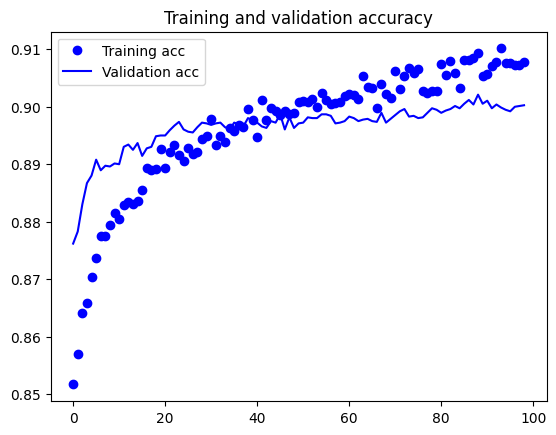

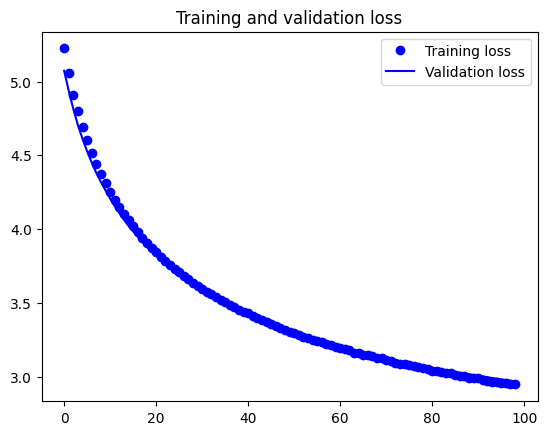

In [107]:
acc = histPreT.history['accuracy'][START_PLOT_FROM_EPOCH:]
val_acc = histPreT.history['val_accuracy'][START_PLOT_FROM_EPOCH:]
loss = histPreT.history['loss'][START_PLOT_FROM_EPOCH:]
val_loss = histPreT.history['val_loss'][START_PLOT_FROM_EPOCH:]

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [108]:
val_acc_per_epoch = histPreT.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 90


# loading best epoch in our model using the checkpoints

In [109]:
best_val_accuracy = max(val_acc_per_epoch)
best_model_file = f'model-{best_epoch:02d}-{best_val_accuracy:.4f}.keras'

print(f'Best model file: {best_model_file}')

Best model file: model-90-0.9021.keras


In [110]:
model_dir= r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints' # C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints

In [111]:
# Construct the full path to the best model file
best_model_path = os.path.join(model_dir, best_model_file)
best_model_path

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\checkpoints\\model-90-0.9021.keras'

In [112]:
os.chdir(model_dir)
Current_dir = os.getcwd()
Current_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\checkpoints'

In [113]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(model_dir) if isfile(join(model_dir, f))]
onlyfiles

['checkpoints.lnk',
 'modelXcep-01-0.8533.keras',
 'modelXcep-02-0.8762.keras',
 'modelXcep-03-0.8783.keras',
 'modelXcep-04-0.8830.keras',
 'modelXcep-05-0.8867.keras',
 'modelXcep-06-0.8880.keras',
 'modelXcep-07-0.8908.keras',
 'modelXcep-13-0.8930.keras',
 'modelXcep-14-0.8934.keras',
 'modelXcep-16-0.8937.keras',
 'modelXcep-20-0.8949.keras',
 'modelXcep-21-0.8950.keras',
 'modelXcep-23-0.8959.keras',
 'modelXcep-24-0.8967.keras',
 'modelXcep-25-0.8974.keras',
 'modelXcep-40-0.8980.keras',
 'modelXcep-47-0.8987.keras',
 'modelXcep-69-0.8989.keras',
 'modelXcep-73-0.8992.keras',
 'modelXcep-74-0.8996.keras',
 'modelXcep-80-0.8997.keras',
 'modelXcep-85-0.9001.keras',
 'modelXcep-87-0.9005.keras',
 'modelXcep-88-0.9012.keras',
 'modelXcep-90-0.9021.keras']

In [115]:
from keras.models import load_model
#loaded_model = load_model(os.path.join('checkpoints',best_model_file))
loaded_model = load_model('modelXcep-90-0.9021.keras') 
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 batch_normalization_9 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                      

## Evaluate

In [116]:
start_time = time.time()

In [117]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

test_loss, test_acc = loaded_model.evaluate(test_generator, steps=len(test_generator))  # steps_per_epoch * epochs
print('test acc:', test_acc)
print('test loss:', test_loss)

Found 6000 images belonging to 2 classes.
188/188 [==============================] - 26s 127ms/step - loss: 3.0158 - accuracy: 0.9018
test acc: 0.9018333554267883
test loss: 3.0157783031463623


In [118]:
print("--- %s Training set > seconds ---" % (time.time() - start_time))

--- 26.09472417831421 Training set > seconds ---


confusion Matrix

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to collect true labels and predictions
true_labels = []
predicted_labels = []

In [120]:
for _ in range(len(test_generator)):
    X, y = next(test_generator)

    yhat = loaded_model.predict(X)
    
    y_true_batch = y # Labels
    
    # Convert probabilities to class labels using a threshold of 0.5
    y_pred_batch = (yhat > 0.5).astype(int)

    # Append the true labels and predictions for this batch to the lists
    true_labels.extend(y_true_batch)
    predicted_labels.extend(y_pred_batch)

    if len(true_labels) >= test_generator.n:
        break

1/1 [==============================] - 1s 592ms/step


In [121]:
# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [122]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[2661,  339],
       [ 250, 2750]], dtype=int64)

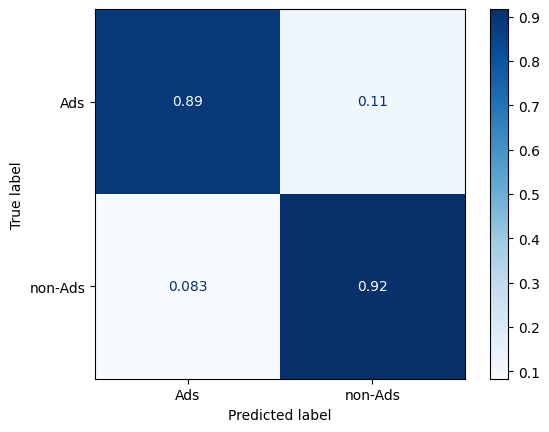

In [123]:
# Plot the confusion matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm/cm_sum.astype(float), display_labels=['Ads', 'non-Ads'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [124]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [125]:

f1_score(true_labels, predicted_labels)

0.9032681885367055

In [126]:
# precision tp / (tp + fp)
precision = precision_score(true_labels, predicted_labels)
precision

0.89025574619618

In [127]:
# recall: tp / (tp + fn)
recall = recall_score(true_labels, predicted_labels)
recall

0.9166666666666666

In [128]:
# ROC AUC
auc = roc_auc_score(true_labels, predicted_labels)
print('ROC AUC: %f' % auc)

ROC AUC: 0.901833
